<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Iceberg_A23a_Sentinel_1_%5Ben%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align='center'><img src='https://drive.google.com/uc?export=view&id=1sli9WYtqrryrtJJYV0p2p7FZHvyvAkjA' height=100px></img></p>

# Monitoring Iceberg A23a with Sentinel-1 SAR images

Author:<br>
[Andre Belem](mailto:andrebelem@id.uff.br) @AntarcticObservatory 2024 (Original language of this notebook:*Portuguese*. The English version was automatically created by [JTranslate](https://github.com/WittmannF/jupyter-translate))

History:<br>
<small>August 2024: Main script build.</small>
<br><br>

Description:<br>
This script uses a combined strategy of `geemap`+`ee`+`cartoee` to build a map with images from the [SAR no Sentinel-1](https://sentiwiki.copernicus.eu/web/s1-applications) sensor, monitoring the [SAR no Sentinel-1](https://sentiwiki.copernicus.eu/web/s1-applications) between June and August 2024, at a time when the iceberg was rotating but with small displacement, about 300 km north of [SAR no Sentinel-1](https://sentiwiki.copernicus.eu/web/s1-applications), probably linked to a divergence associated with a *Taylor Column* (to read a little more about the subject, visit [SAR no Sentinel-1](https://sentiwiki.copernicus.eu/web/s1-applications)).


In [ ]:
# For timelapse animations, we will need ffmpeg. We will also need the cartopy
# Note that this is only important for COLAB, but you can adapt it on your local machine if you need to
!pip install -q ffmpeg-python
!pip install -q cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.8 MB/s eta 0:00:00


### Remember! First, start by authenticating to ee

Just to remember that you need to authenticate with `ee` before starting. And note that you have to change it to your `project-id`

In [ ]:
import ee
import geemap
ee.Authenticate()

In [ ]:
# Here you must change the project to "YOUR-PROJECT-ID"
ee.Initialize(project='ee-andrebelem')

## A little more about the Iceberg A23a

A23a is a large tabular iceberg that broke off from the Filchner-Ronne Ice Shelf in 1986 and ended up being trapped at shallow depths in the Weddell Sea for many years, but in 2020 it began to slowly move north, as normally happens with most icebergs, and where they will likely thaw completely. However, in 2024, monitoring of the iceberg showed that it stopped a little north of the South Orkney Islands, in a place where there is a divergence of currents, potentially a Taylor column, and it is possible that it could become trapped there for a period of time. good time, just spinning.

**Monitoring Strategy**<br>
We set aside a monitoring area by first looking at some images in [WorldView](https://worldview.earthdata.nasa.gov/?v=-54.67420288845136,-63.99909408798844,-37.75513555509842,-55.98545092204455&t=2024-08-07-T11%3A57%3A36Z) using a simple map and image coordinates. Note that you can use `map.user_roi` directly in `ee`. The area is approx., and it is approx. 114063.84 km² (or 44040.26 miles²), north of the Orkney Islands, to filter the Sentinel 1 images with `filterBounds()`. With the help of [WorldView](https://worldview.earthdata.nasa.gov/?v=-54.67420288845136,-63.99909408798844,-37.75513555509842,-55.98545092204455&t=2024-08-07-T11%3A57%3A36Z), we convert the coordinates into a monitoring polygon, and later into an `Earth Engine` element.

In [ ]:
# Monitoring polygon data. This area was defined by studying some images with WorldView
monitoring_polygon = {
    'geodesic': False,
    'type': 'Polygon',
    'coordinates': [
        [
            [-48.5, -61.0],
            [-48.5, -56.5],
            [-44.5, -56.6],
            [-44.5, -61.0],
            [-48.5, -61.0]
        ]
    ]
}
# Create the ee.Geometry.Polygon object
roi_A23a = ee.Geometry.Polygon(
    coords=monitoring_polygon['coordinates'],
    proj=ee.Projection('EPSG:4326'),  # It is necessary to specify the CRS, which in the case of those waters is WGS84
    geodesic=monitoring_polygon['geodesic']
)

In [ ]:
# Calculate the area in square meters
area_m2 = roi_A23a.area(ee.ErrorMargin(1)).getInfo()

# Convert to square kilometers
area_km2 = area_m2 / 1e6
# Convert to square miles
area_miles2 = area_km2 / 2.58999

# Displays the results
print(f"The area of ​​ROI A23a is approximately {area km2:.2f} km²")
print(f"The area of ​​ROI A23a is approximately {area_miles2:.2f} miles²")

A área do ROI A23a é aproximadamente 114063.84 km²
A área do ROI A23a é aproximadamente 44040.26 milhas²


In [ ]:
# Note that this is a simple map, which filters by the monitoring area and takes the first image
map = geemap.Map(center=(-58.6125775, -46.538086), zoom=6)
map.add_basemap("Esri.AntarcticBasemap")

# choosing images from repository
image = (
    ee.ImageCollection("COPERNICUS/S1_GRD")
    .filterDate("2024-08-01", "2024-08-08")
    .filterBounds(roi_A23a)
    .first()
)

vis = {
    "min": -25,
    "max": 5,
    "bands": ["HH"] # <--- note that this will only work for images that have HH
}
map.add_layer(image, vis, "Sentinel-1")
# Add the polygon with border
region_style = {
    'color': '000000',
    'width': 1,
    'lineType': 'solid',
    'fillColor': '00000000',
}
map.addLayer(roi_A23a,region_style, "A23a Monitoring BBox")
map

Map(center=[-58.6125775, -46.538086], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=S…

### Some important considerations:
*Note that the image is distorted because we are already at higher latitudes.
* Eventually if you are monitoring a moving object (like the Iceberg), you will need to actually look for which image it appears, especially with SAR where the images are of very high resolution (hint: you can use [PolarView](https://www.polarview.aq/antarctic), especially the map which punctuates the location of icebergs)
* Also eventually, you will have to use a min-max composition in the band configuration that you will visualize. Here, -25 to 5 is enough for Sentinel's *HH* band. But nothing stops you from studying this beforehand.

This *cookie-cutter approach* will not always work for your example and location. Explore the possibilities.

Now I'm going to define a *smaller* monitoring polygon, which fits both the Orcadas Islands and Iceberb A23a...

In [ ]:
# Monitoring polygon data. This area was defined by studying some images and using Map.user_roi
polygon_data = {
    'geodesic': False,
    'type': 'Polygon',
    'coordinates': [
        [
            [-47.988281, -59.321981],
            [-47.988281, -57.903174],
            [-45.087891, -57.903174],
            [-45.087891, -59.321981],
            [-47.988281, -59.321981]
        ]
    ]
}


# Create the ee.Geometry.Polygon object
roi_A23a = ee.Geometry.Polygon(
    coords=polygon_data['coordinates'],
    proj=ee.Projection('EPSG:4326'),  # It is necessary to specify the CRS, which in the case of those waters is WGS84
    geodesic=polygon_data['geodesic']
)

Now, let's separate all images from a certain period, and that coincide with any part within the monitoring area.

**Tip:** An effective monitoring strategy is to define a very small area. Otherwise, even a single pixel within the area will select the image as valid.

In [ ]:
# choosing images from repository
collection = (
    ee.ImageCollection("COPERNICUS/S1_GRD")
    .filterDate("2024-06-01", "2024-08-07")
    .filterBounds(roi_A23a)
)

count = collection.size().getInfo()
print(f"Number of images selected in the period:{count:.0f}")

Número de imagens selecionadas no período:20


Let's obtain data from the images and create a dataframe with important information about each one. You will notice that each image set contains `bands` and `angle`. For more information, read [aqui](https://developers.google.com/earth-engine/guides/sentinel1). Another important detail is that here we calculate the intersection of the image with the ROI, or percentage of overlap. With this, we can choose to process only those where this proportion is > 40%.

**Important tip**: If you are building a similar monitoring program, be careful to build it little by little. The `image.getInfo()` function gives you all the information contained in an image and it is using *gemini* or *chatgpt* that you can quickly build a function like the one below.

In [ ]:
from datetime import datetime
import pandas as pd
from tqdm import tqdm

# Converts the collection to a list
image_list = collection.toList(count)

# List to store data
data = []

# calculate the area of ​​the Iceberg's ROI
roi_area = roi_A23a.area(ee.ErrorMargin(1)).getInfo()

# Use tqdm to show progress
for idx in tqdm(range(count), desc="Processando imagens"):
    image = ee.Image(image_list.get(idx))

    # Calculates the intersection of the image with the ROI and the proportion of the image area within the ROI
    intersection = image.geometry().intersection(roi_A23a, ee.ErrorMargin(1))
    proportion = (intersection.area(ee.ErrorMargin(1)).getInfo() / roi_area) * 100

    image_info = image.getInfo()

    # Extract and format the date from 'segmentStartTime'
    timestamp = image_info['properties']['segmentStartTime']
    date_time = datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')

    # Extract bands and concatenate band names
    bands = image_info['bands']
    band_names = ', '.join([band['id'] for band in bands])

    # Extracts information
    crs = bands[0]['crs'] if bands else None
    image_id = image_info['id']
    polarization = ', '.join(image_info['properties']['transmitterReceiverPolarisation'])
    orbit_pass = image_info['properties']['orbitProperties_pass']
    resolution_meters = image_info['properties']['resolution_meters']

    # Adds information to the DataFrame
    data.append({
        'Bands': band_names,
        'CRS': crs,
        'ID': image_id,
        'Polarization': polarization,
        'Date Time': date_time,
        'Orbit Pass': orbit_pass,
        'Resolution (m)': resolution_meters,
        'Proportion': proportion
    })

# Builds the DataFrame
df_sentinel = pd.DataFrame(data)

Processando imagens: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [ ]:
# Let's see what our dataframe looks like
df_sentinel

Bands         CRS                                                 ID  \
0   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240604T07...   
1   HH, angle  EPSG:32722  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240607T22...   
2   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240609T07...   
3   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240616T07...   
4   HH, angle  EPSG:32722  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240619T22...   
5   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240621T07...   
6   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240626T22...   
7   HH, angle  EPSG:32722  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240701T22...   
8   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240703T07...   
9   HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240708T22...   
10  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240710T07...   
11  HH, angle  EPSG:32722  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240713T22...   
12  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240715T07...   
13  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240720T22...   
14  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240722T07...   
15  HH, angle  EPSG:32722  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240725T22...   
16  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240727T07...   
17  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240801T22...   
18  HH, angle  EPSG:32723  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240803T07...   
19  HH, angle  EPSG:32722  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20240806T22...   

   Polarization            Date Time  Orbit Pass  Resolution (m)  Proportion  
0            HH  2024-06-04 07:18:26  DESCENDING              40    0.829618  
1            HH  2024-06-07 22:46:33   ASCENDING              40   47.611393  
2            HH  2024-06-09 07:27:10  DESCENDING              40   55.154223  
3            HH  2024-06-16 07:18:25  DESCENDING              40    0.835261  
4            HH  2024-06-19 22:46:33   ASCENDING              40   47.571263  
5            HH  2024-06-21 07:27:10  DESCENDING              40   55.136602  
6            HH  2024-06-26 22:38:27   ASCENDING              40   99.691417  
7            HH  2024-07-01 22:46:32   ASCENDING              40   47.667401  
8            HH  2024-07-03 07:27:09  DESCENDING              40   55.125067  
9            HH  2024-07-08 22:38:27   ASCENDING              40   99.686257  
10           HH  2024-07-10 07:18:24  DESCENDING              40    0.832618  
11           HH  2024-07-13 22:46:32   ASCENDING              40   47.670626  
12           HH  2024-07-15 07:27:09  DESCENDING              40   55.253749  
13           HH  2024-07-20 22:38:26   ASCENDING              40   99.685735  
14           HH  2024-07-22 07:18:24  DESCENDING              40    0.829624  
15           HH  2024-07-25 22:46:31   ASCENDING              40   47.754096  
16           HH  2024-07-27 07:27:08  DESCENDING              40   55.216353  
17           HH  2024-08-01 22:38:26   ASCENDING              40   99.692325  
18           HH  2024-08-03 07:18:24  DESCENDING              40    0.847474  
19           HH  2024-08-06 22:46:31   ASCENDING              40   47.726920

You may have noticed that some images are really bad! (little overlap), so we can select the one that has the best overlap here.

In [ ]:
# Finds the index of the line with the highest intersection ratio
best_image_index = df_sentinel['Proportion'].idxmax()
print(f"The index of the image with the highest intersection is: {best_image_index}")

O índice da imagem com a maior interseção é: 17


Now, let's create a snapshot of each image and record it as GeoTiff, focusing on the monitoring area. Note that I will use the `data` column of our dataframe to place a caption. Let's see what it will look like in the first image, to calibrate details...

In [ ]:
# Creating a map with geemap
image = ee.Image(image_list.get(int(best_image_index))) # <--- note that I selected the best of all

map = geemap.Map()
map.add_basemap("Esri.AntarcticBasemap")
vis = {
    "min": -25,
    "max": 5,
    "bands": ["HH"] # <--- note that this will only work for images that have HH
}
map.add_layer(image, vis, "Sentinel-1")

# Add the polygon with border
region_style = {
    'color': '000000',
    'width': 1,
    'lineType': 'solid',
    'fillColor': '00000000',
}
map.addLayer(roi_A23a,region_style, "A23a Monitoring BBox")
# Centering the map on the ROI with zoom 7
map.centerObject(roi_A23a, zoom=7)

map

Map(center=[-58.61049865853728, -46.538085999999836], controls=(WidgetControl(options=['position', 'transparen…

Now, I'm going to create a MAP using cartopy and the image!

With a little *pythonism*... I'll try to estimate an area 50% larger than my monitoring BBox defined by `roi_A23a`...

In [ ]:
# Get the coordinates of the BBox (Bounding Box)
coords = roi_A23a.bounds().coordinates().getInfo()[0]
min_lon, min_lat = coords[0]
max_lon, max_lat = coords[2]

# Calculate the center of roi_A23a
center_lon = (min_lon + max_lon) / 2
center_lat = (min_lat + max_lat) / 2

# Set w and h to 50% of BBox width and height or use predefined values
w = (max_lon - min_lon) / 2 if (max_lon - min_lon) / 2 > 0 else 2
h = (max_lat - min_lat) / 2 if (max_lat - min_lat) / 2 > 0 else 0.8

# Define the new region based on the center and the values ​​of w and h
region = [center_lon + w, center_lat - h, center_lon - w, center_lat + h]

# Display information in a clear and organized way
print(f"Centro do ROI A23a: Longitude = {center_lon:.6f}, Latitude = {center_lat:.6f}")
print(f"Largura (w): {w:.2f}, Altura (h): {h:.2f}")
print(f"Defined region: {region}")


Centro do ROI A23a: Longitude = -46.538086, Latitude = -58.612578
Largura (w): 1.45, Altura (h): 0.71
Região definida: [-45.087891, -59.321981, -47.988281, -57.903174]


### **Decisions must be made**

Producing a map depends on some considerations, such as centering the monitored object, having some references, etc. So, it is common to first create a test map, and modify it until you get the result you want. Therefore, be aware that the **cookie-cutter approach** below may be bad in your case!

In [ ]:
# First, I'm going to copy the Antarctic Observatory logo here
!gdown 1sli9WYtqrryrtJJYV0p2p7FZHvyvAkjA

Downloading...
From: https://drive.google.com/uc?id=1sli9WYtqrryrtJJYV0p2p7FZHvyvAkjA
To: /content/AO_logo.png
100% 52.2k/52.2k [00:00<00:00, 52.7MB/s]


'2024-08-01 22:38:26'

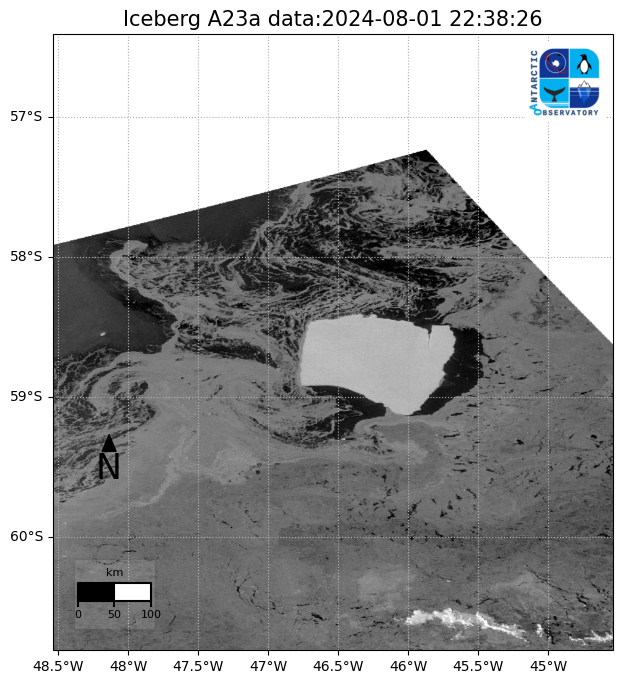

In [ ]:
# Now let's create a simple map with the calculated coordinates

from geemap import cartoee
from cartopy import crs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logo_path = '/content/AO_logo.png'
logo_img = mpimg.imread(logo_path)

data=df_sentinel.loc[best_image_index, 'Date Time'] # <--- note that this is taken from the best image I plotted above

w = 2 # <--- I am "manually" defining the size I want in degrees of lat/lon
h = 2.2

region = [center_lon + w, center_lat - h, center_lon - w, center_lat + h]

fig = plt.figure(figsize=(10, 8))

# use the card to get the image
ax = cartoee.get_map(image, region=region, vis_params=vis)

# Add gridlines to the map at specific intervals
cartoee.add_gridlines(ax, interval=[0.5, 1.0], linestyle=":")

# add a north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.35),
    "arrow_length": 0.055,
    "text_color": "black",
    "arrow_color": "black",
    "fontsize": 25,
    "width": 2,
    "headwidth": 10,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# Add a scale
scale_bar_full_dict = {
    "metric_distance":50,
    "unit": "km",
    "at_x": (0.05, 0.5),
    "at_y": (0.08, 0.11),
    "max_stripes":2,
    "fontsize": 8,
    "font_weight": "normal",
    "bbox_kwargs": {'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.1}
}
cartoee.add_scale_bar(ax, **scale_bar_full_dict)

ax.set_title(label=f"Iceberg A23a data:{data}", fontsize=15)

# Add the logo in the top right corner
logo_ax = fig.add_axes([0.585, 0.77, 0.2, 0.1], anchor='NE', zorder=1)
logo_ax.imshow(logo_img)
logo_ax.axis('off')  # Remove the axes from the logo

plt.show()

**!! FANTASTIC!!** This was the result we were looking for. You can modify this map however you want, until it looks beautiful and has everything you want.

### Animations

Now, let's produce animations with the images selected from this repository. I'm only going to use images that have an overlapping ratio >40%, and I decided that I'm going to produce them one by one, recording them in PNG, and then I'm going to create an animated GIF and an MP4 with the result. These previous definitions are important!

Processando imagem 01 2024-06-07 22:46:33 proporção de cobertura:47.61
Processando imagem 02 2024-06-09 07:27:10 proporção de cobertura:55.15
Processando imagem 03 2024-06-19 22:46:33 proporção de cobertura:47.57
Processando imagem 04 2024-06-21 07:27:10 proporção de cobertura:55.14
Processando imagem 05 2024-06-26 22:38:27 proporção de cobertura:99.69
Processando imagem 06 2024-07-01 22:46:32 proporção de cobertura:47.67
Processando imagem 07 2024-07-03 07:27:09 proporção de cobertura:55.13
Processando imagem 08 2024-07-08 22:38:27 proporção de cobertura:99.69
Processando imagem 09 2024-07-13 22:46:32 proporção de cobertura:47.67
Processando imagem 10 2024-07-15 07:27:09 proporção de cobertura:55.25
Processando imagem 11 2024-07-20 22:38:26 proporção de cobertura:99.69
Processando imagem 12 2024-07-25 22:46:31 proporção de cobertura:47.75
Processando imagem 13 2024-07-27 07:27:08 proporção de cobertura:55.22
Processando imagem 14 2024-08-01 22:38:26 proporção de cobertura:99.69
Proces

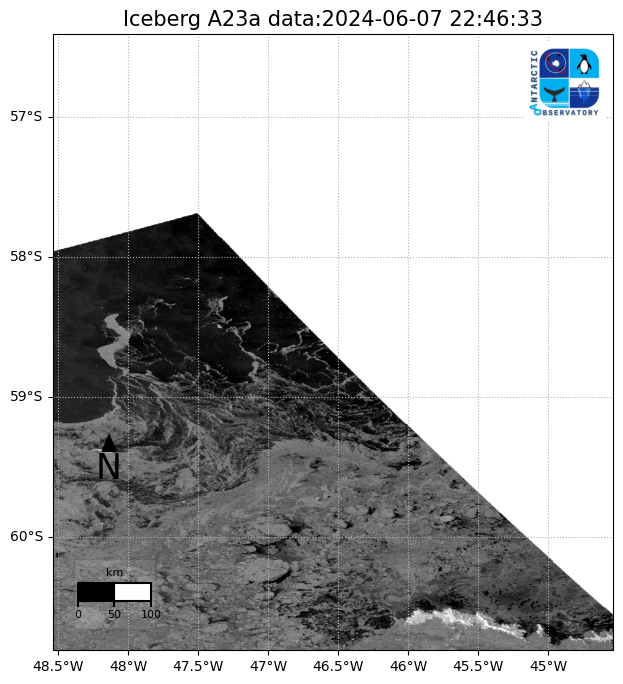

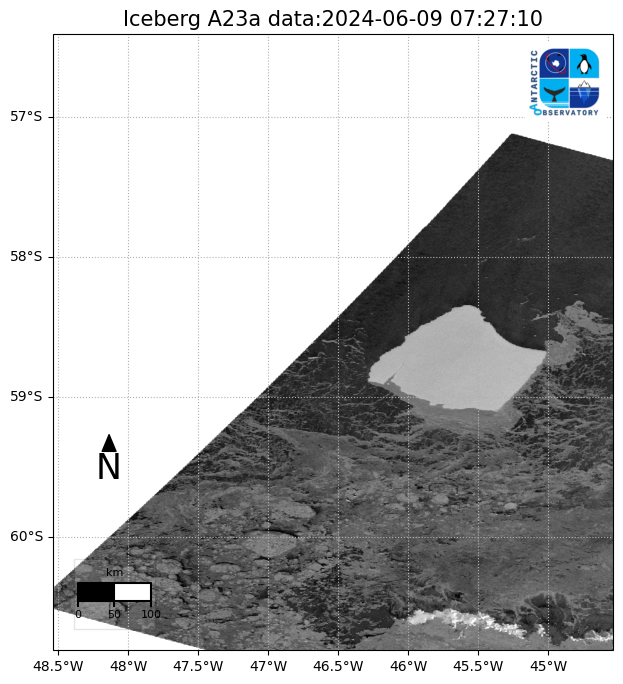

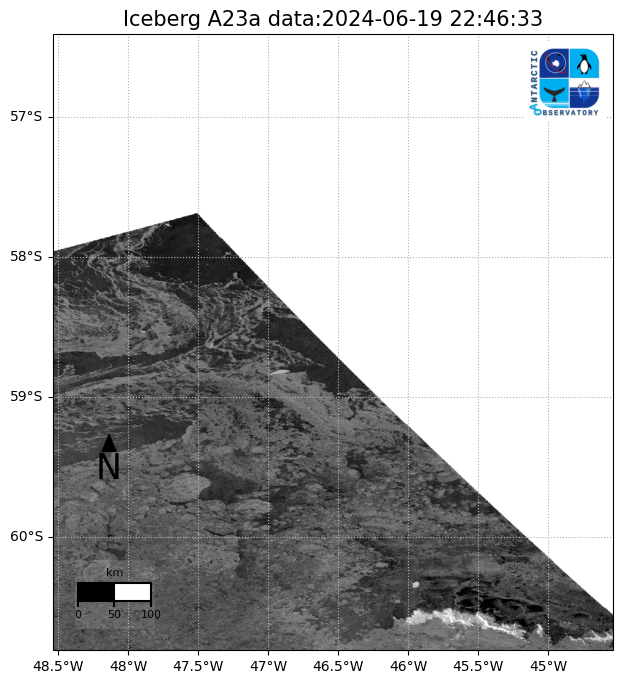

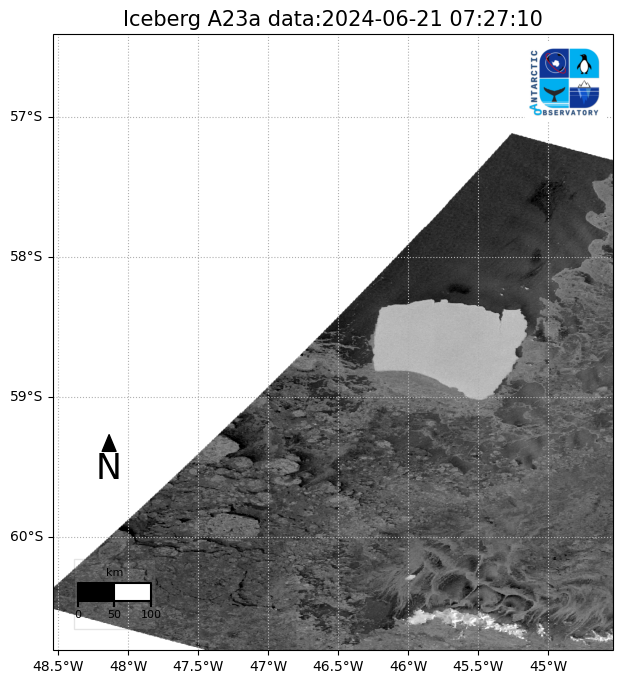

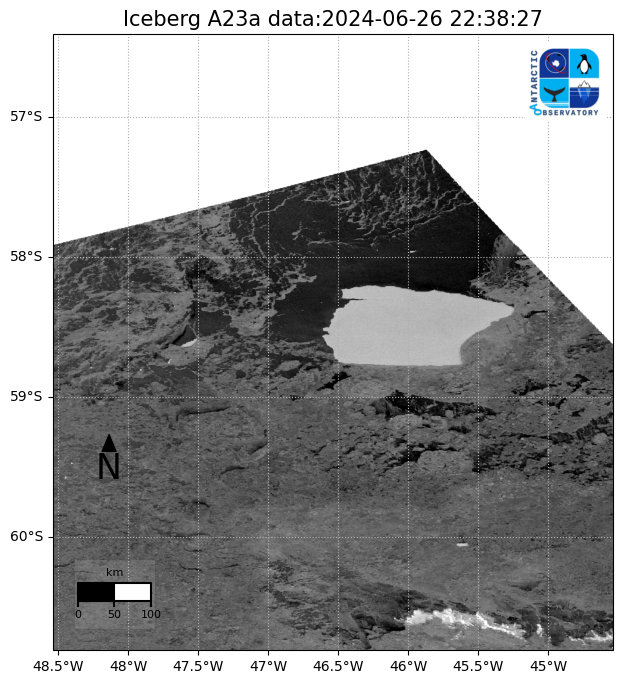

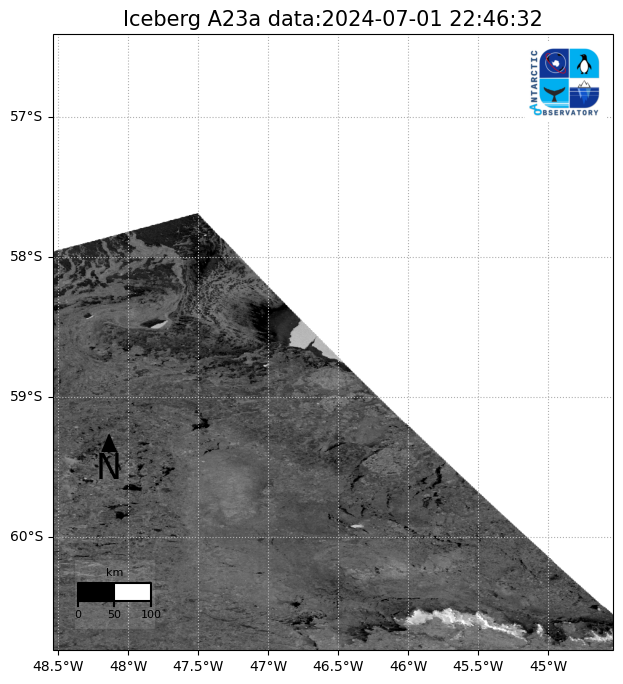

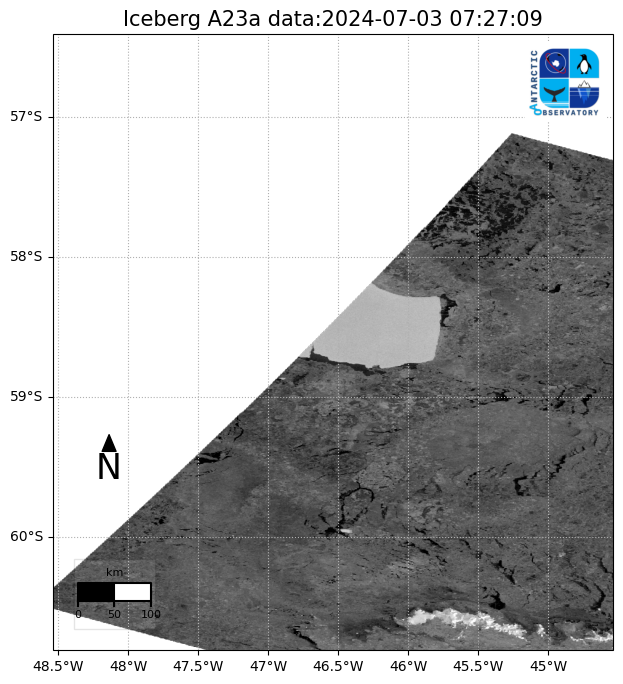

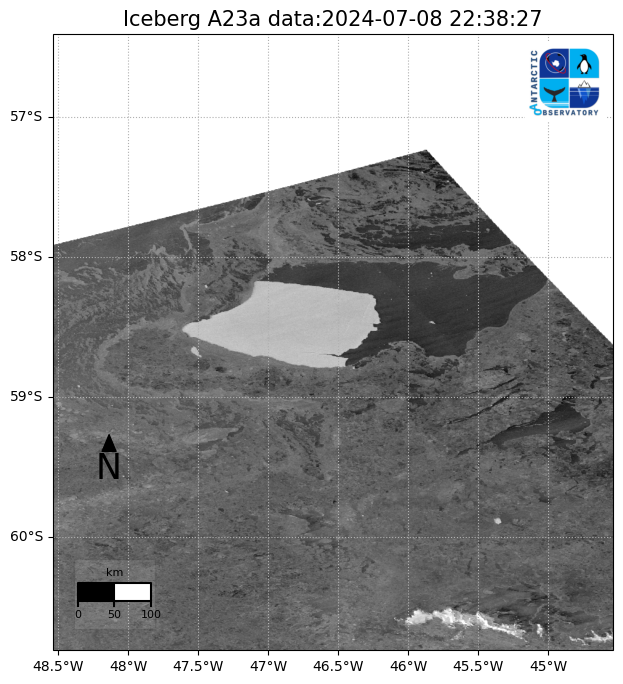

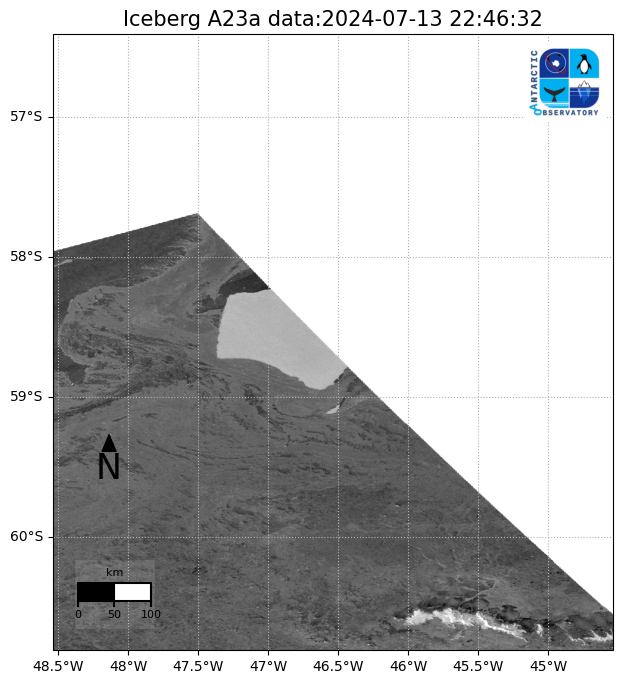

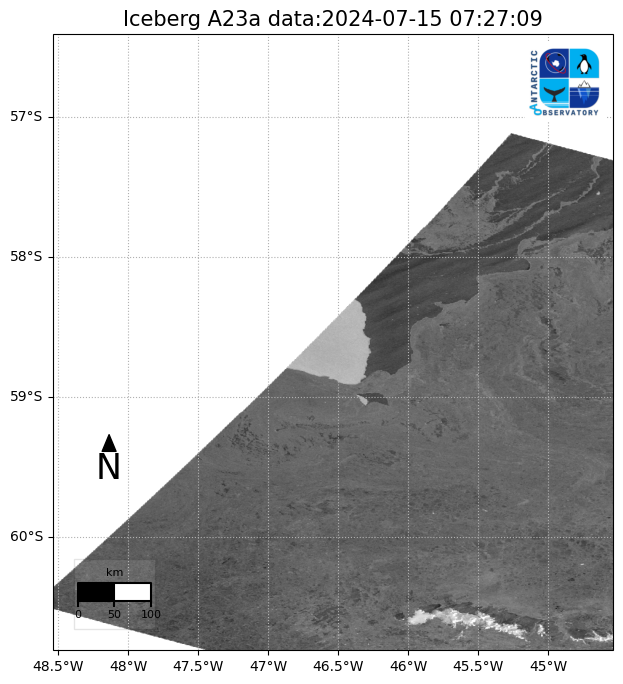

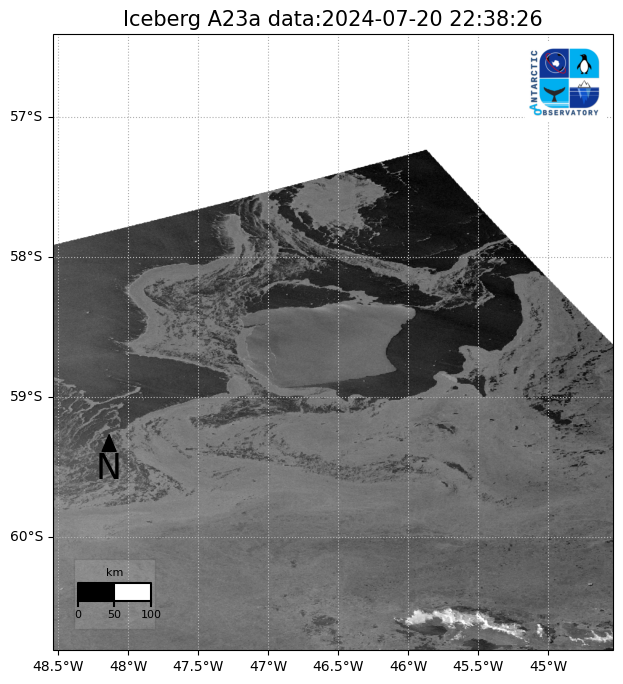

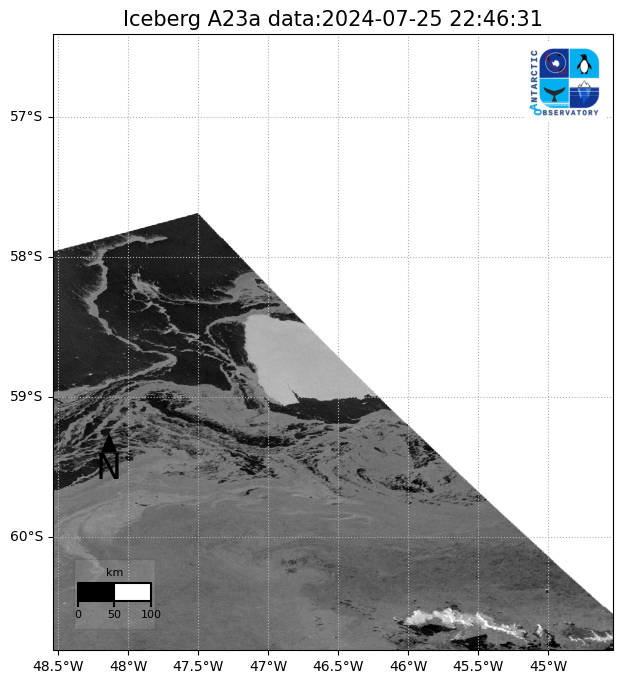

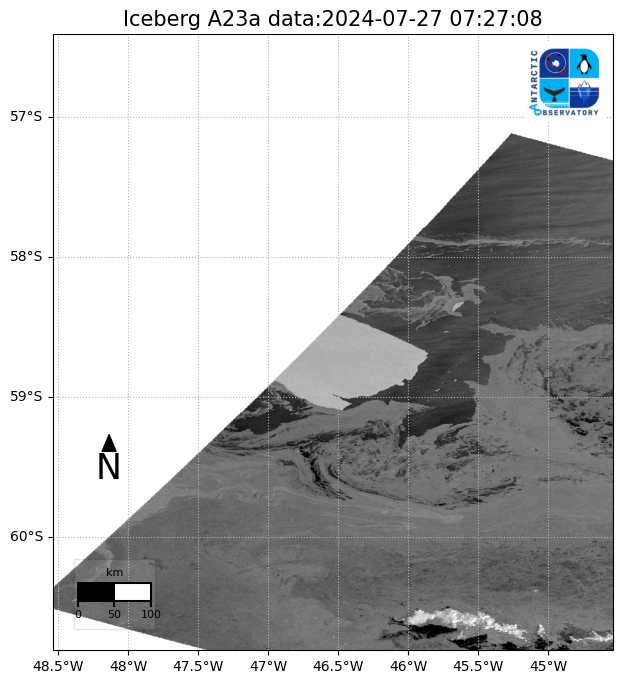

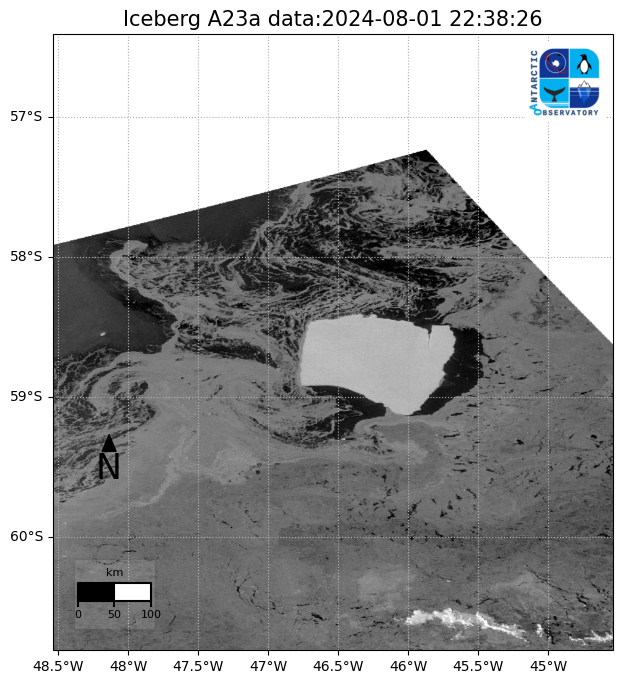

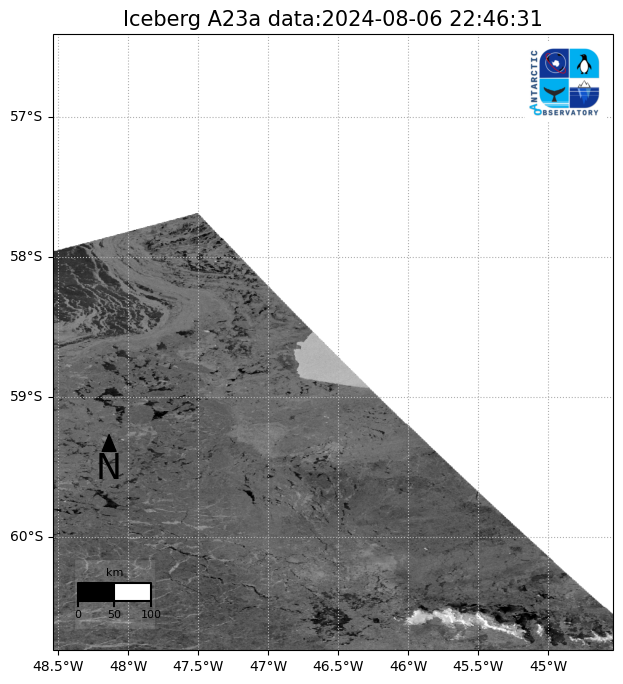

In [ ]:
# For consistency, I will repeat some things here....
logo_path = '/content/AO_logo.png'
logo_img = mpimg.imread(logo_path)

# defined the region
w = 2
h = 2.2
region = [center_lon + w, center_lat - h, center_lon - w, center_lat + h]

count = 0 # <-- I add a counter for the image name
for index, row in df_sentinel.iterrows(): # <-- I will interact by dataframe rows
    if row['Proportion'] < 40:
        continue  # <-- if it is less than 40, skip to the next line

    # otherwise, execute...
    image = ee.Image(image_list.get(int(index)))
    count = count + 1

print(f"Processing image {count:02d} {row["Date Time"]} coverage ratio:{row["Proportion"]:.2f}")
    data = row['Date Time']
    image = ee.Image(image_list.get(int(index)))

    fig = plt.figure(figsize=(10, 8))

    # take the image
    ax = cartoee.get_map(image, region=region, vis_params=vis)

    # add gridlines
    cartoee.add_gridlines(ax, interval=[0.5, 1.0], linestyle=":")

    # north arrow
    north_arrow_dict = {
        "text": "N",
        "xy": (0.1, 0.35),
        "arrow_length": 0.055,
        "text_color": "black",
        "arrow_color": "black",
        "fontsize": 25,
        "width": 2,
        "headwidth": 10,
        "ha": "center",
        "va": "center",
    }
    cartoee.add_north_arrow(ax, **north_arrow_dict)

    # scale
    scale_bar_full_dict = {
        "metric_distance":50,
        "unit": "km",
        "at_x": (0.05, 0.5),
        "at_y": (0.08, 0.11),
        "max_stripes":2,
        "fontsize": 8,
        "font_weight": "normal",
        "bbox_kwargs": {'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.1}
    }
    cartoee.add_scale_bar(ax, **scale_bar_full_dict)

    ax.set_title(label=f"Iceberg A23a data:{data}", fontsize=15)

    # Add the logo in the top right corner
    logo_ax = fig.add_axes([0.585, 0.77, 0.2, 0.1], anchor='NE', zorder=1)
    logo_ax.imshow(logo_img)
    logo_ax.axis('off')  # Remove the axes from the logo

    # writes the image to a file
    output_filename = f"{count:02d}_icebergA23a_map.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')

### Animations with ffmpeg

`ffmpeg` is an external program that we install here in our virtual machine (note that this is valid for use in COLAB), and we will run it from inside the notebook with `!`. If you are running locally on windows, you will probably have to adapt this code.

Basically we set the command line to a *frame rate* of 2 images per second.

In [ ]:
# now creates an mp4 with the generated images
!ffmpeg -framerate 2 -i %02d_icebergA23a_map.png -vf "scale=iw-mod(iw\,2):ih-mod(ih\,2)" -c:v libx264 -r 30 -pix_fmt yuv420p icebergA23_Jul-Ago2024_video.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Now an animated gif, in a loop and also with a *frame rate* of 2. Note that we *pulled* the color palette so that the image is clearer.

In [ ]:
# and now an animated gif with a unique color palette
# Create an optimized palette
!ffmpeg -i %02d_icebergA23a_map.png -vf "palettegen" palette.png

# Use the palette to create the animated GIF
!ffmpeg -framerate 2 -i %02d_icebergA23a_map.png -i palette.png -lavfi "paletteuse" -gifflags +transdiff -y animated_icebergA23_Jul-Ago2024.gif

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Now, if you want to download, just run the code below
from google.colab import files
files.download('animated_icebergA23_Jul-Ago2024.gif')
files.download('icebergA23_Jul-Ago2024_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conclusion

This notebook demonstrated a practical example of monitoring using Sentinel-1 images, integrating the capabilities of `geemap` and `cartoee` for analysis and visualization of geospatial data. Through these tools, it was possible to process and interpret radar images, allowing research into the dynamics of a specific iceberg and its behavior over time.

The use of technologies such as Sentinel-1, combined with the processing power of Google Earth Engine and the flexibility of Python libraries, highlights the importance and potential of environmental monitoring in near real-time. This example reinforces how such approaches are essential for scientific research.

If you have suggestions, questions or considerations about this notebook, just send an email to [o autor](mailto:andrebelem@id.uff.br).